## Approach

1. Load data
2. Differential expression analysis on the Wild Type Untreated
3. Clustering Strategy
4. Annotation of the rest of the samples
5. Marker genes analysis

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys




%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (9,6)
#sns.set(rc={'figure.figsize':(9,6)})
sc.set_figure_params(dpi = 300)

prefix = 'paper-data/'
output_prefix = 'paper-final/'
sc.settings.figdir = output_prefix + 'figs/'




### 1. Load All Samples

In [2]:
ann = sc.read_h5ad(prefix + '/full-dataset.h5ad')


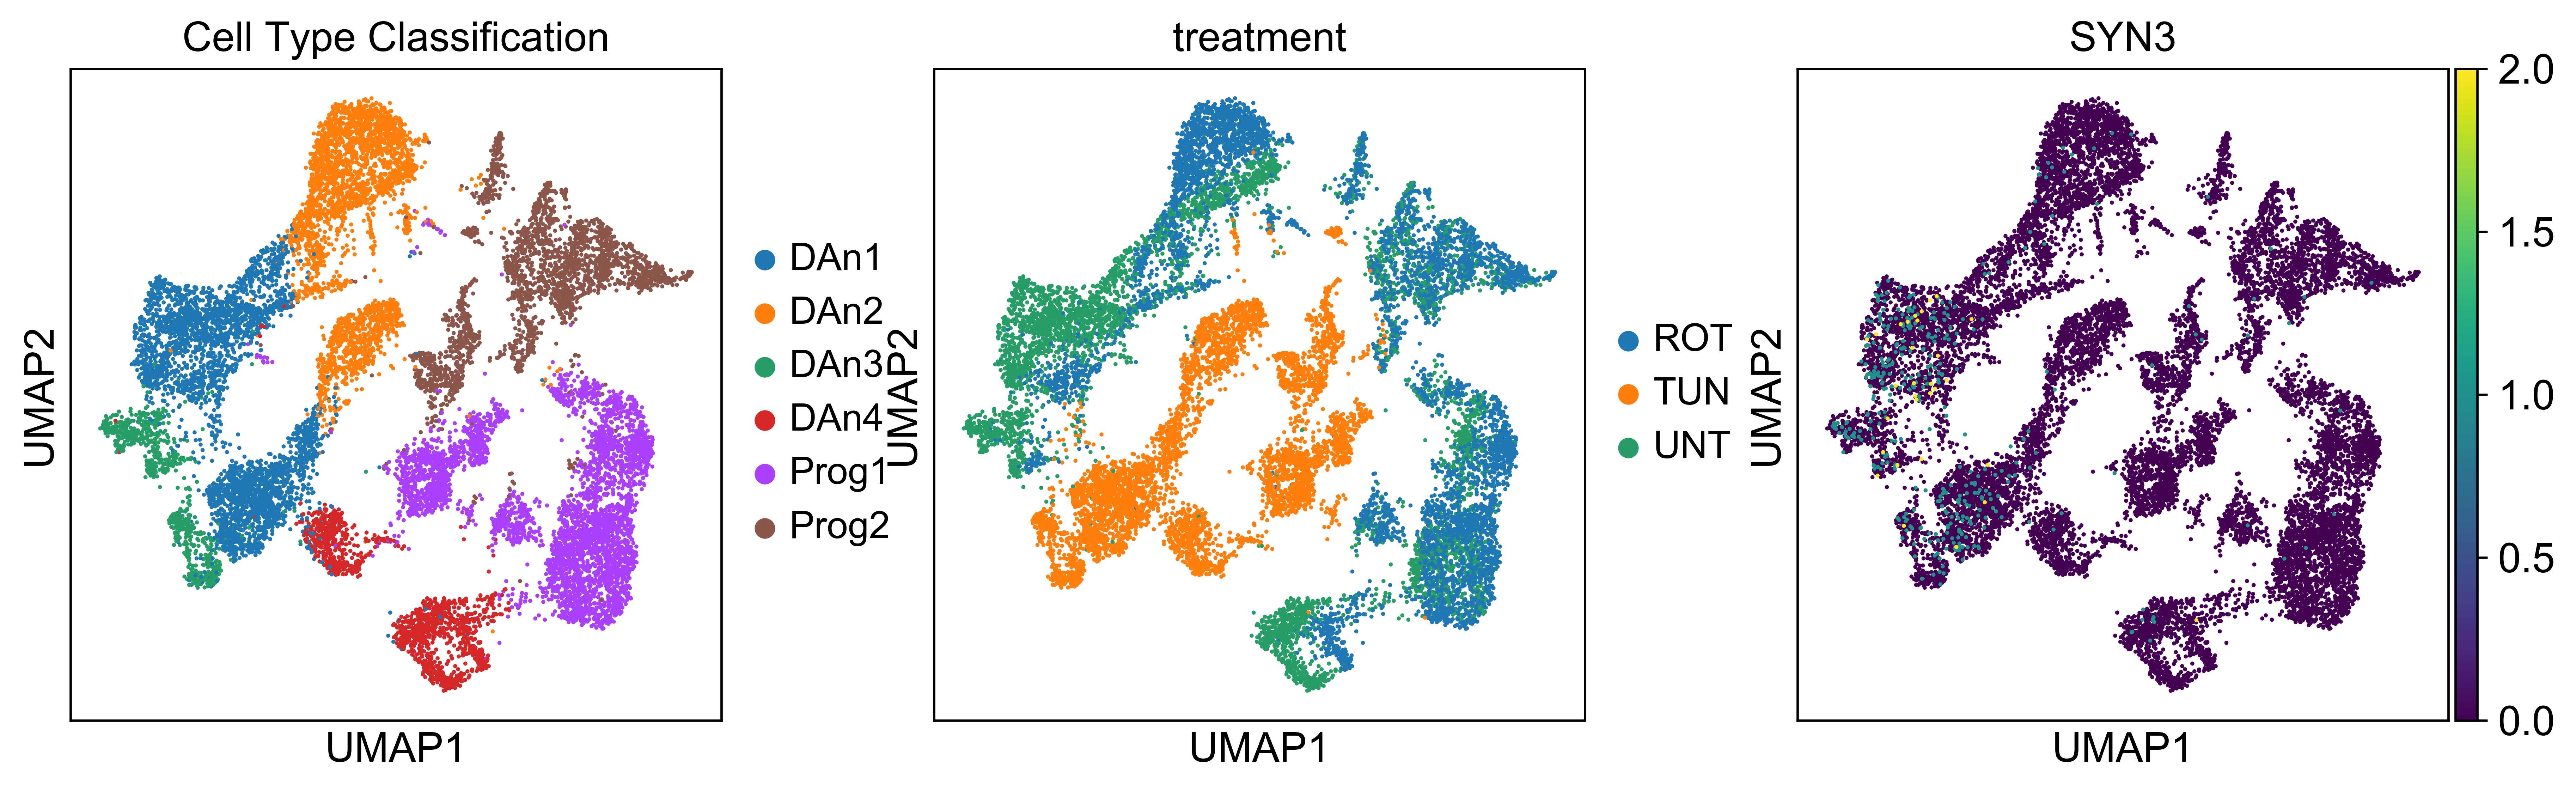

In [3]:
sc.pl.umap(ann, color = ['Cell Type Classification','treatment','SYN3'])


### 2. Differential expression analysis for  differentiated population

In [4]:
adata_unt = ann[ann.obs['sample'] == 'WT_UNT'].copy()
#sns.distplot(adata_unt.X.max(axis = 1).A)



#sc.pp.calculate_qc_metrics(adata_unt, inplace=True, percent_top = False)


We observe the median of gene of the different tissues across different cell types. This way we can robustly observe tendencies that may be driving the differential expression analysis in different tissues

## Export marker genes for the WT UNT sample

In [5]:
from sklearn.metrics import mutual_info_score
import math
def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi


def permutation_test(x,y, func = None, reps=10000):
    from sklearn.model_selection import train_test_split
    sig = 0
    cutoff = func(x) - func(y)
    v = np.concatenate((x,y))
    for rep in range(reps):
        X1, X2 = train_test_split(v, test_size=len(x), shuffle = True)
        null_model = func(X1) - func(X2)
        #print(null_model, cutoff,len(X1))
        if abs(null_model) > abs(cutoff):
            sig +=1
    return float(sig) / reps
            


from scipy.stats import levene

def calc_levene(x,y):
    x,pval = levene(x,y, center = 'median')
    return pval

def dump(recarrays, prefix = 'diffexp', mi_df = None, obs_label = 'Cell Type Classification'):
    results = {}
    fields = ['names','scores', 'logfoldchanges', 'pvals_adj']
    sample_names = recarrays[fields[0]].dtype.names
    for sample in sample_names:
        
        deg = pd.DataFrame({fname: recarrays[fname][sample] for fname in fields})
        #deg = deg[deg['pvals_adj'] < 0.1]
        print(sample,len(deg))
        mi = {}
        lvn = {}
        pt = {}
        if mi_df:
            X = mi_df.X.copy()
            ct = mi_df.obs[obs_label] == sample
            ct = ct.values.astype(int) # 0 , 1
            for gene_name in deg['names']:
                #print(gene_name)
                g = X[:,mi_df.var_names == gene_name]
                g = g.A.reshape(-1)
                mi[gene_name] = calc_MI(g, ct, (math.ceil(g.max()/np.log(2)) + 1,2))
                x,y = g[ct == 0],g[ct == 1]
                lvn[gene_name] = calc_levene(x, y)
                #pt[gene_name] = permutation_test(x, y, func = np.mean)
                #print(pt[gene_name])
            s = pd.Series(list(mi.values()),index = list(mi.keys()))
            eqvar = pd.Series(list(lvn.values()),index = list(lvn.keys()))
            deg['rank'] = np.arange(0,len(deg))
            deg = deg.set_index('names')
            deg['mutual_info'] = s
            deg['levene'] = eqvar
            
        deg.to_csv(prefix + sample + '.csv')
        deg.sort_values('mutual_info', ascending=False).head(200).to_csv(prefix + sample + '-top200.csv')
        results[sample] = deg

    return results





sc.pp.filter_genes(adata_unt, min_cells = 10)
sc.tl.rank_genes_groups(adata_unt, 'Cell Type Classification', n_genes=adata_unt.X.shape[1], use_raw=False, method = 'wilcoxon')
results_unt = dump(adata_unt.uns['rank_genes_groups'], prefix = 'diffexp/culture/', mi_df = adata_unt)


adata_unt_neuronal = adata_unt[adata_unt.obs['Cell Type Classification'].isin(['DAn1', 'DAn2', 'DAn3'])].copy()
sc.pp.filter_genes(adata_unt_neuronal, min_cells = 10)
sc.tl.rank_genes_groups(adata_unt_neuronal, 'Cell Type Classification',use_raw = False, n_genes=adata_unt_neuronal.X.shape[1], method = 'wilcoxon')

results_neuronal = dump(adata_unt_neuronal.uns['rank_genes_groups'], prefix = 'diffexp/neuronal/',  mi_df=adata_unt_neuronal)




DAn1 15957
DAn2 15957
DAn3 15957
DAn4 15957
Prog1 15957
Prog2 15957
DAn1 14944
DAn2 14944
DAn3 14944


## Oxidative Stress Effect in the individual cell types

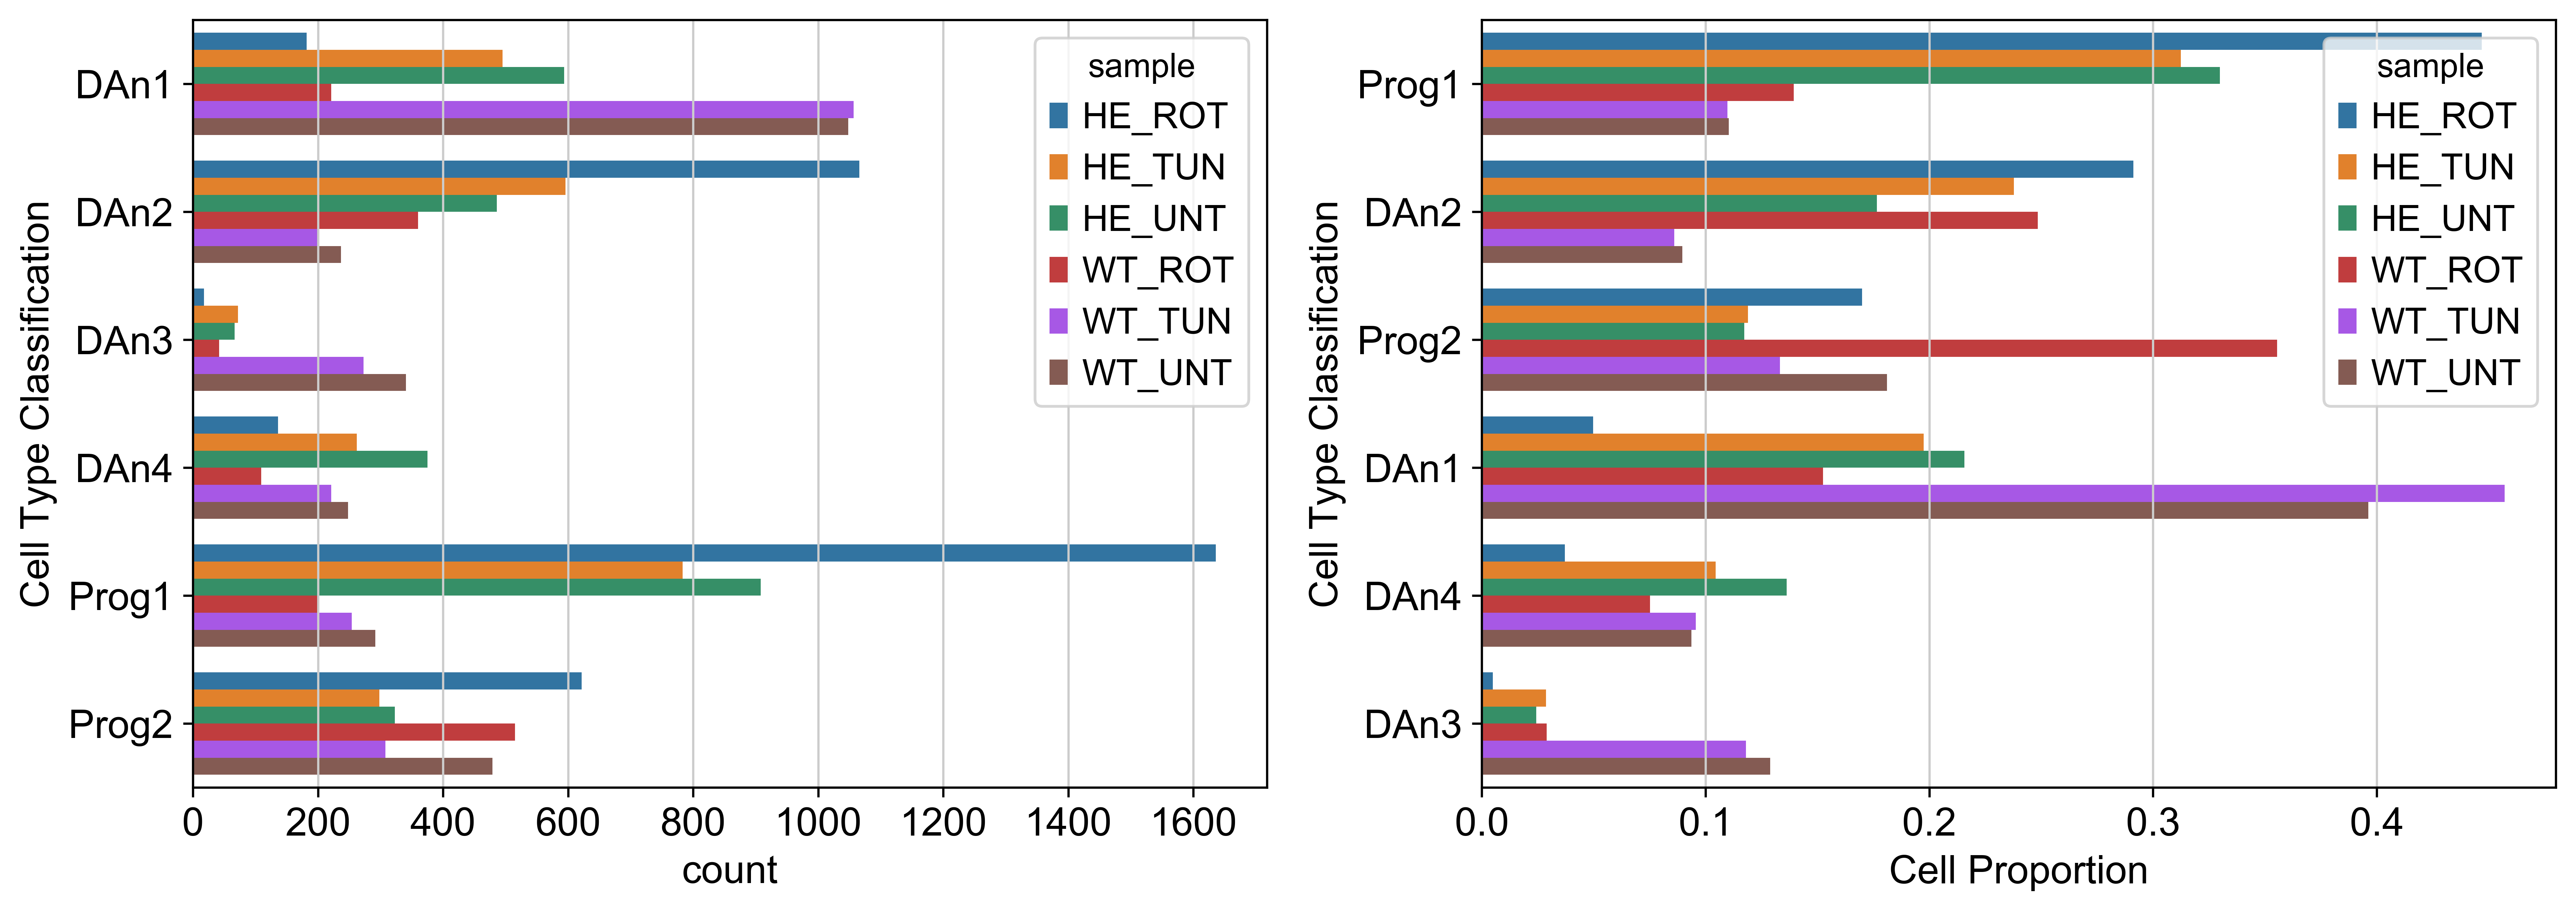

In [6]:
f, ax = plt.subplots(1, 2, figsize = (15,5))

sns.countplot(y = 'Cell Type Classification', hue = "sample", data=ann.obs, ax = ax[0])
prop_df = (ann.obs['Cell Type Classification']
           .groupby(ann.obs['sample'])
           .value_counts(normalize=True)
           .rename('Cell Proportion')
           .reset_index())

sns.barplot(y = 'Cell Type Classification', x = 'Cell Proportion', hue = 'sample', data = prop_df, ax = ax[1])



### Have a look in the mitochondrial methylation markers

In [7]:

#sc.pl.umap(adata_all , color = ['Cell Type Classification','sample','SLC25A26'])
#adata_final.obs[gene_name] = adata_final.X[:, adata_final.var.index == gene_name ].A

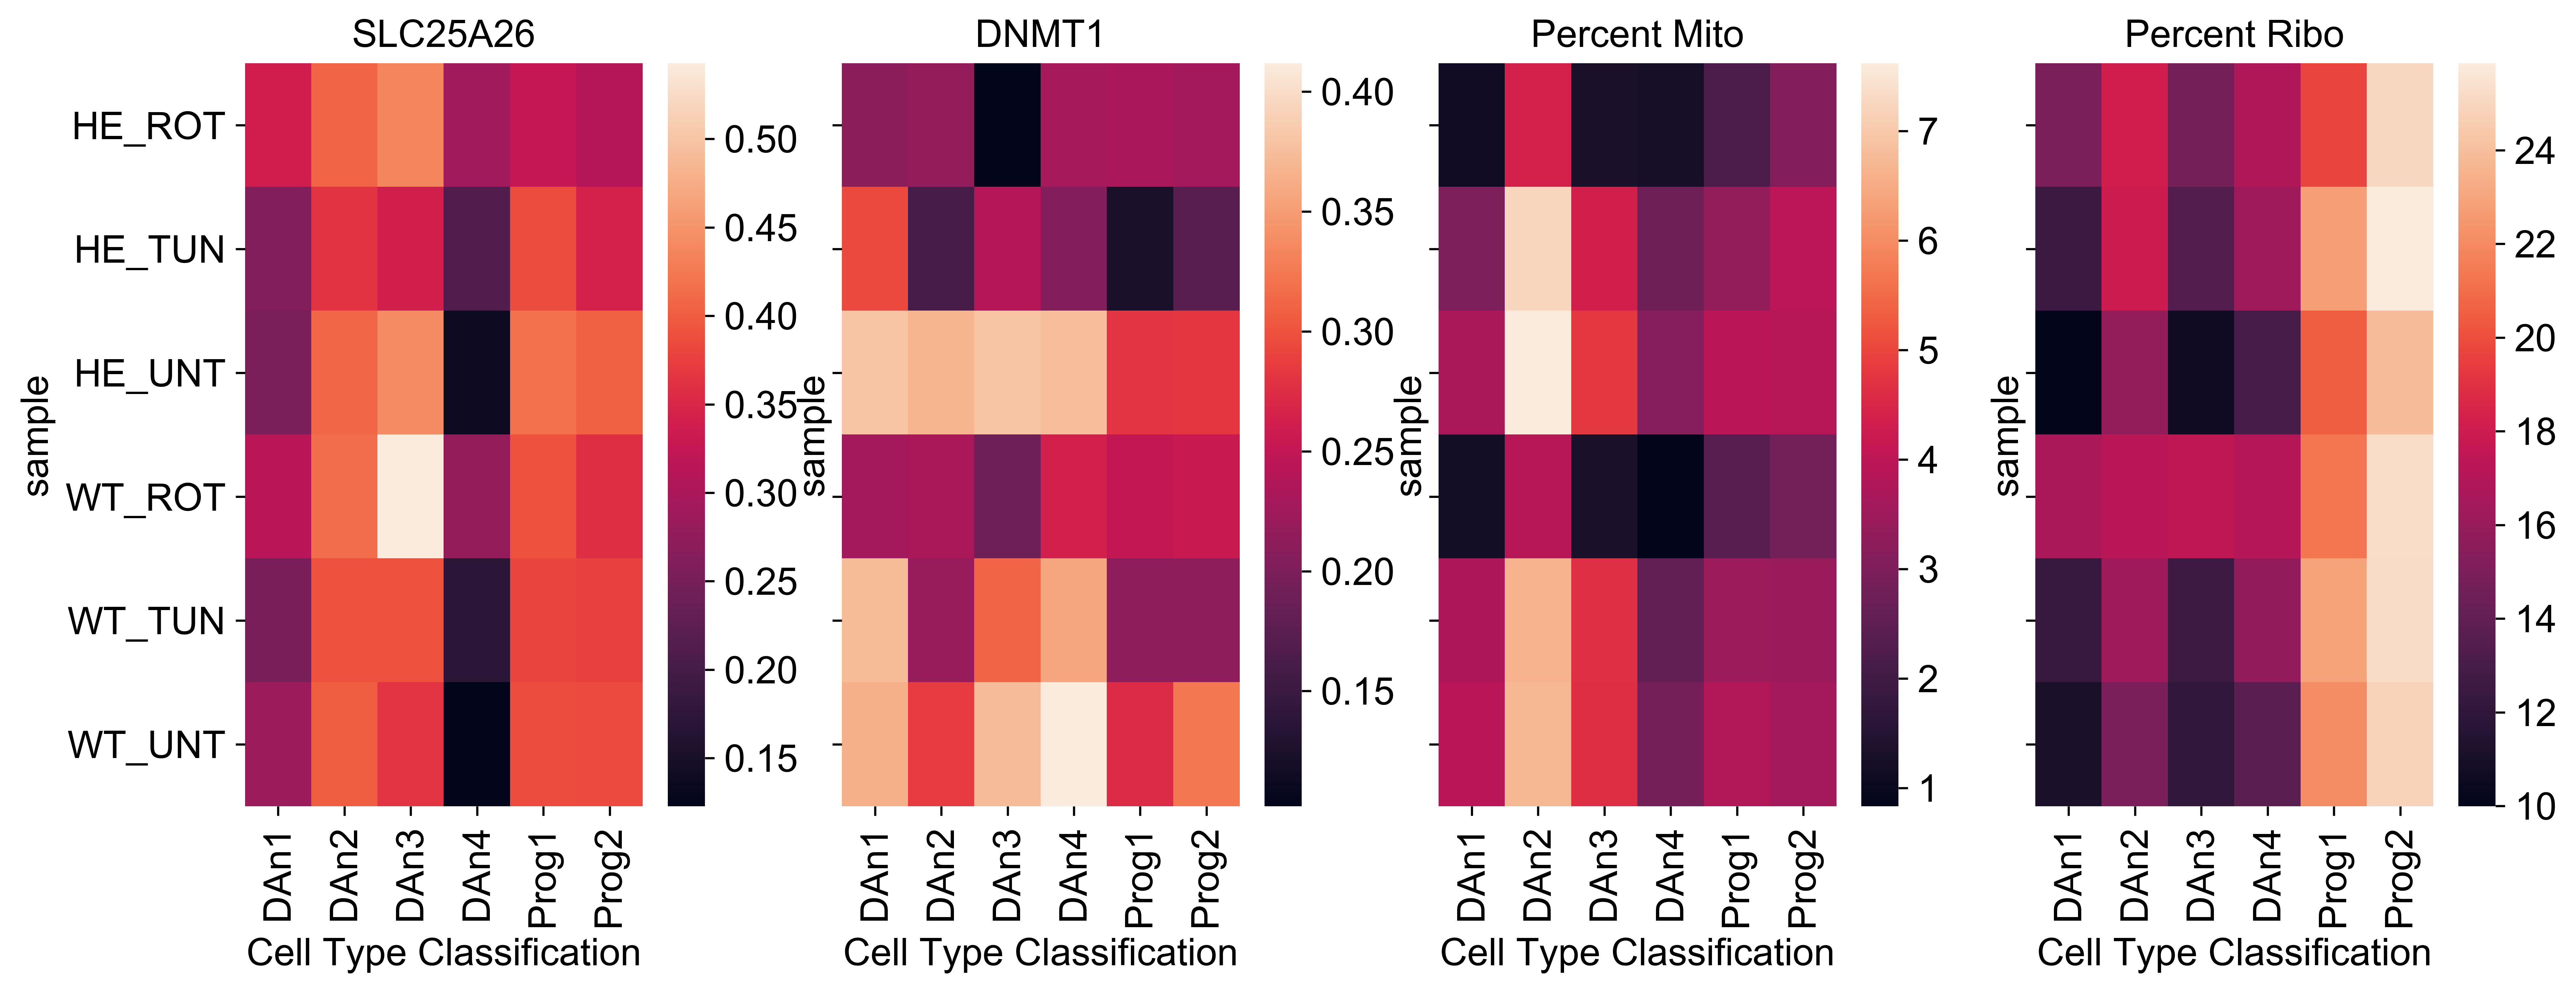

In [8]:
adata_final = ann
f, ax = plt.subplots(1, 4, figsize = (15,5), sharey=True)

gene_name = 'SLC25A26'

adata_final.obs[gene_name] = adata_final.X[:, adata_final.var.index == gene_name ].A

ax[0].set_title(gene_name)
sns.heatmap(adata_final.obs.groupby(['sample', 'Cell Type Classification'])[gene_name].mean().unstack(), ax = ax[0])


gene_name = 'DNMT1'

adata_final.obs[gene_name] = adata_final.X[:, adata_final.var.index == gene_name ].A
ax[1].set_title(gene_name)
sns.heatmap(adata_final.obs.groupby(['sample', 'Cell Type Classification'])[gene_name].mean().unstack(), ax = ax[1],)


ax[2].set_title('Percent Mito')

sns.heatmap(adata_final.obs.groupby(['sample', 'Cell Type Classification'])['percent_mito'].mean().unstack(), ax = ax[2],)


ax[3].set_title('Percent Ribo')

sns.heatmap(adata_final.obs.groupby(['sample', 'Cell Type Classification'])['percent_ribo'].mean().unstack(), ax = ax[3],)



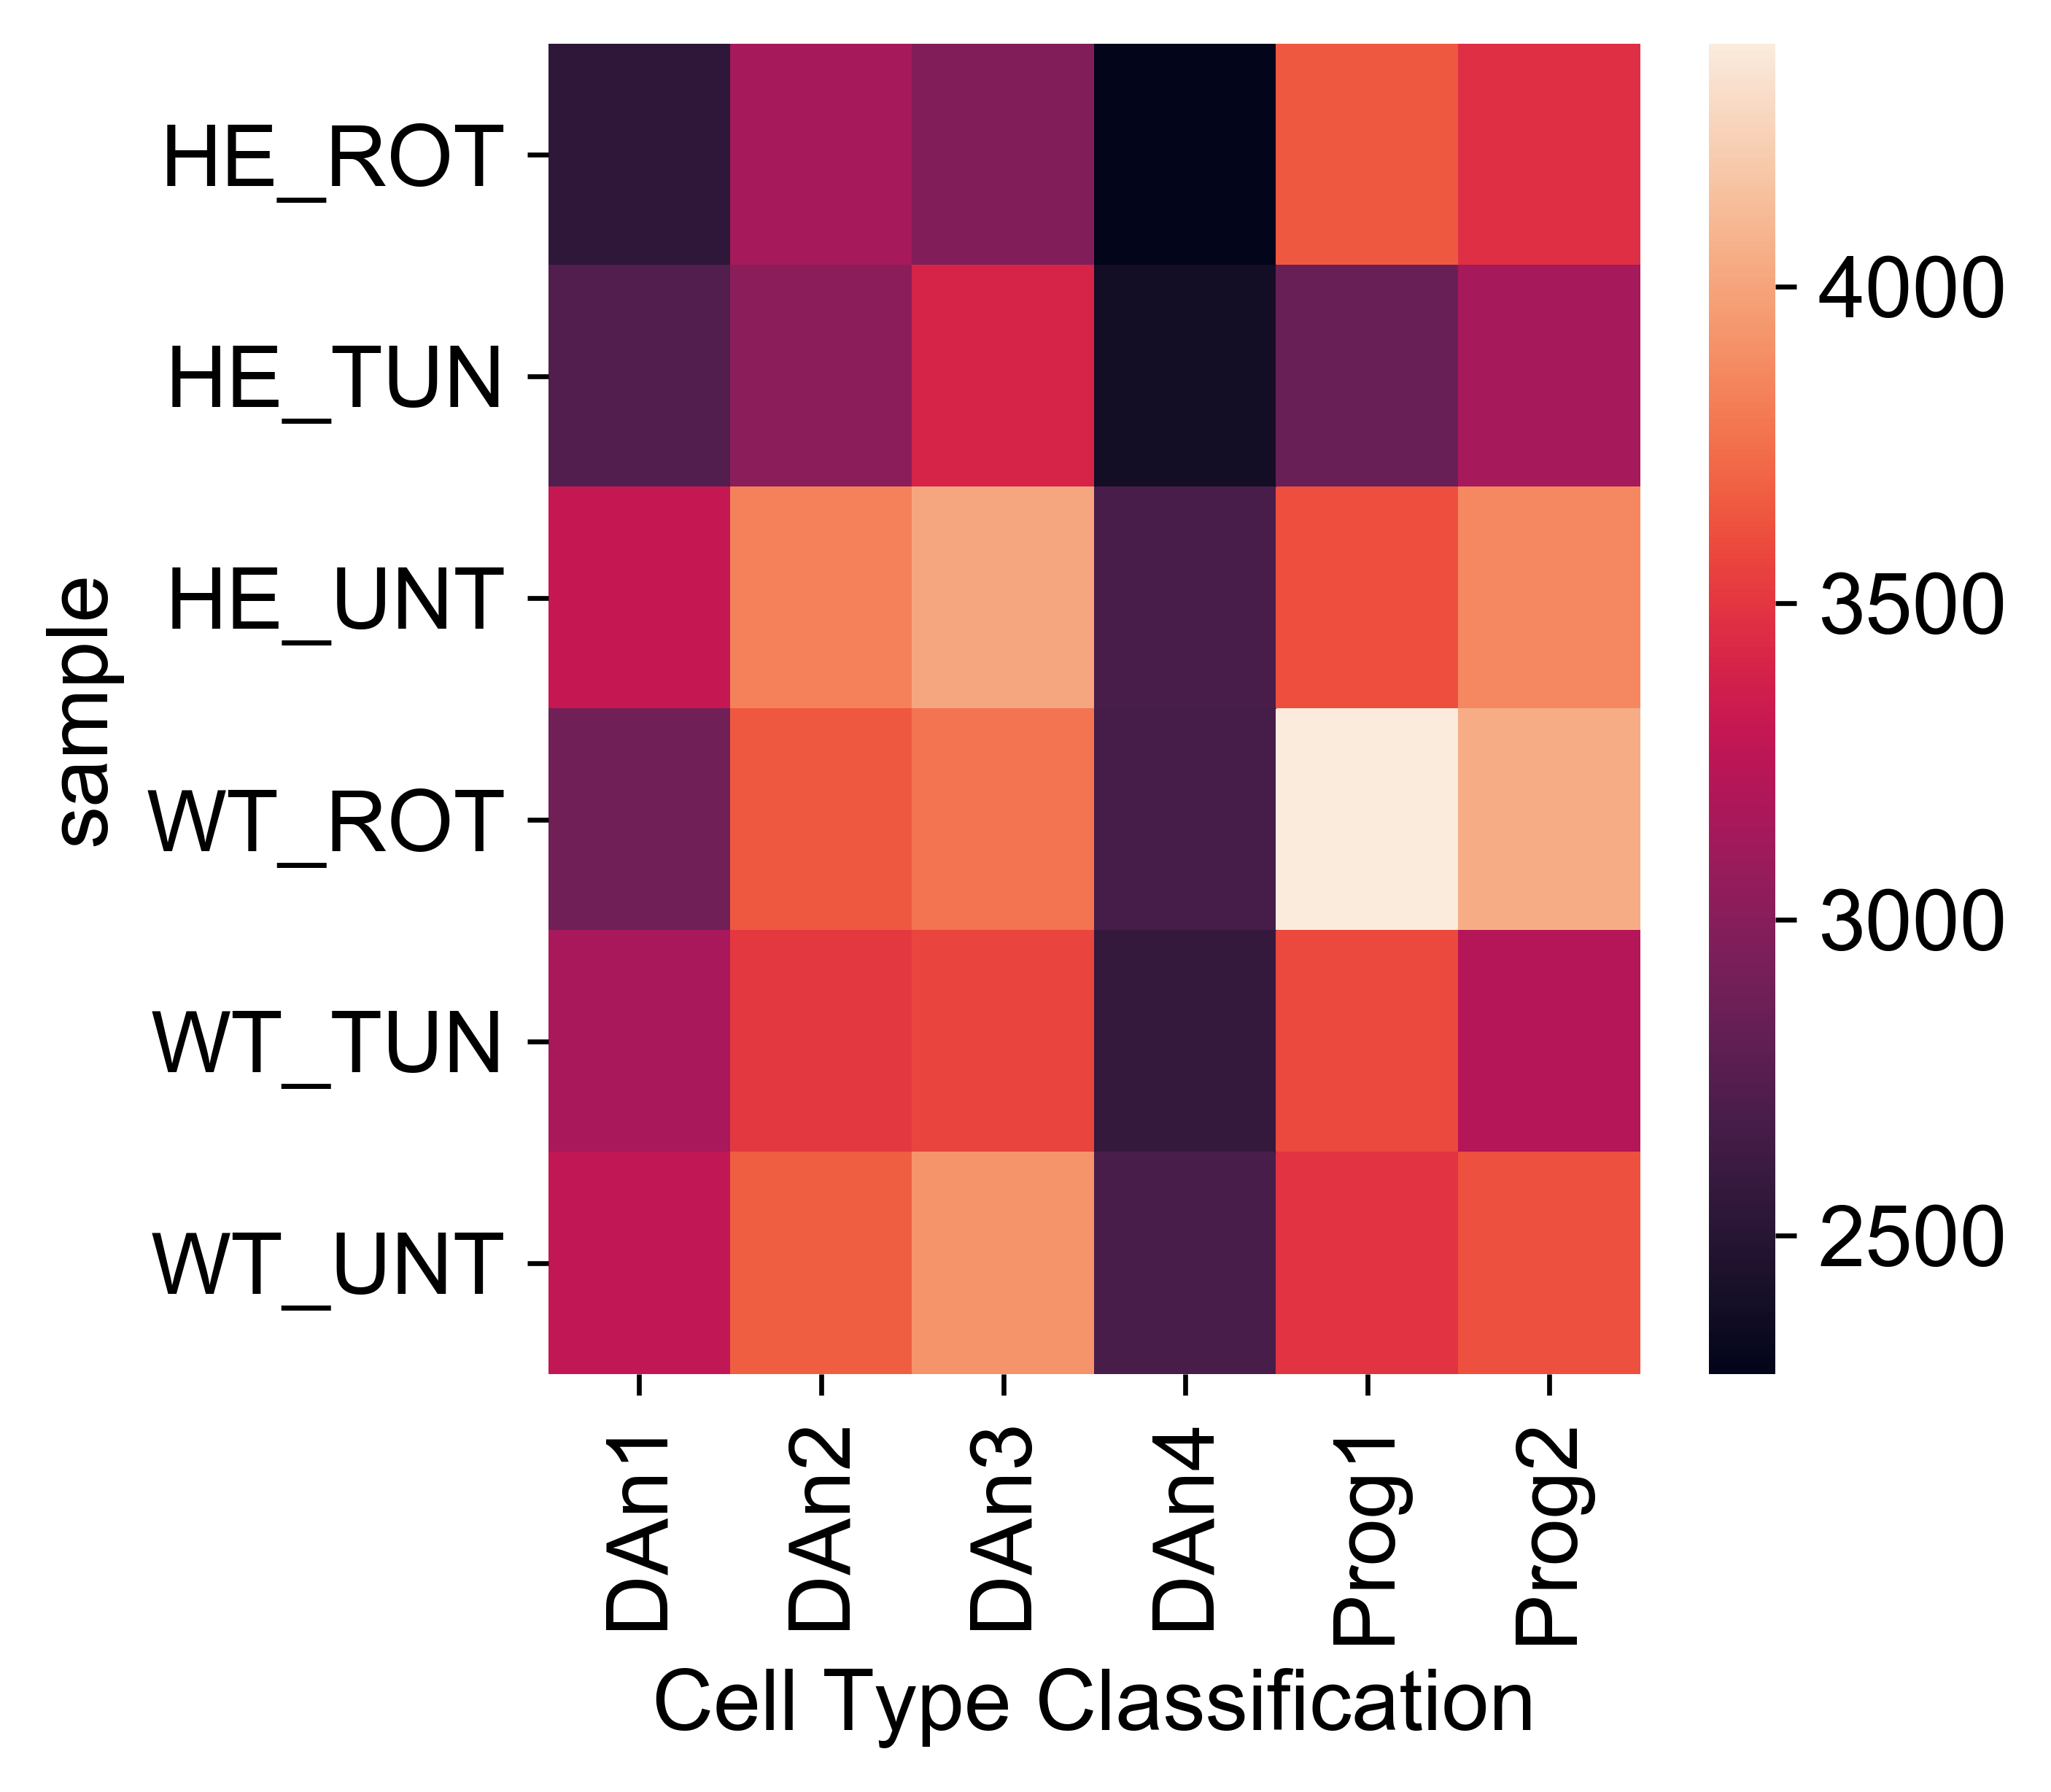

In [9]:



sns.heatmap(adata_final.obs.groupby(['sample', 'Cell Type Classification'])['n_genes_by_counts'].mean().unstack())

#sc.pl.matrixplot(adata_all[adata_all.obs['Cell Type Classification'].isin(['DAn2'])], 'SLC25A26', groupby = 'sample')
#sns.heatmap(data = adata_all.obs, x = 'sample', y = 'Cell Type Classification', hue = 'SLC25A26')


## Genotype effect with respect to the treatments and the cell type


In [23]:
import itertools

def dump(recarrays, 
         prefix = 'diffexp',
         mi_params = None,
         obs_label = 'Cell Type Classification'
        ):
    
    if isinstance(mi_params, dict):
        reference = mi_params['reference']
        level = mi_params['level']
        mi_df = mi_params['df']
    
    results = {}
    fields = ['names','scores', 'logfoldchanges', 'pvals_adj']
    sample_names = recarrays[fields[0]].dtype.names
    for sample in sample_names:
        print(sample)
        deg = pd.DataFrame({fname: recarrays[fname][sample] for fname in fields})
        #deg = deg[deg['pvals_adj'] < 0.1]
        results[sample] = deg
        mi = {}
        lvn = {}
        if isinstance(mi_params,dict):
            if reference != 'rest':
                mi_test = mi_df[mi_df.obs[level].isin([reference, sample])]
            else:
                mi_test =  mi_df
            X = mi_test.X.copy()
            ct = mi_test.obs[obs_label] == sample
            ct = ct.values.astype(int)
            for gene_name in deg['names']:
                #print(gene_name)
                g = X[:, mi_df.var_names == gene_name]
                g = g.A.reshape(-1)
                mi[gene_name] = calc_MI(g, ct, (math.ceil(g.max()/np.log(2)) + 1,2))
                lvn[gene_name] = calc_levene(g[ct == 0],g[ct == 1])
            s = pd.Series(list(mi.values()),index = list(mi.keys()))
            eqvar = pd.Series(list(lvn.values()),index = list(lvn.keys()))
            deg['rank'] = np.arange(0,len(deg))
            deg = deg.set_index('names')
            deg['mutual_info'] = s
            deg['levene'] = eqvar
        
        df_up = deg[deg['scores'] > 0].sort_values('mutual_info', ascending=False)
        
        df_down = deg[deg['scores'] < 0].sort_values('mutual_info', ascending=False)
        df_up200 = df_up.head(200)
        df_down200 = df_down.head(200)
        if (df_down200['pvals_adj'] > 0.05).sum() > 0 or (df_up200['pvals_adj'] > 0.05).sum() > 0:
            print('Problem in ' + prefix + sample + '-upreg-top200.csv')
        else:
            print('All is good')
        
        df_up200.to_csv(prefix + sample + '-upreg-top200.csv')
        df_down200.to_csv(prefix + sample + '-downreg-top200.csv')
        
        df_up.to_csv(prefix + sample + '-upreg.csv')
        df_down.to_csv(prefix + sample + '-downreg.csv')
    return results



def rank_genes(ann_test, 
               level_names, 
               compare, 
               groups = 'all', 
               reference = 'rest', 
               mutual_info = False):
    import os
    levels = {}
    for l in level_names:
        levels[l] = list(ann_test.obs[l].unique())
    
    level_keys = list(levels.keys())
    for cvar in itertools.product(*list(levels.values())):
        ann_tmp = ann_test
        # Isolate based on the level_names uniqueness
        print(cvar)
        for key, value in zip(level_keys, cvar):
            ann_tmp = ann_tmp[ann_tmp.obs[key] == value]
        ann_tmp = ann_tmp.copy()
        
        # Filter genes that are not robustly expressed
        sc.pp.filter_genes(ann_tmp, min_cells=ann_tmp.X.shape[0]/10)
        print('Genes:' , ann_tmp.X.shape[1])
        
        #print(ann_tmp.obs.groupby(compare).size())
        #print(ann_tmp.obs.groupby('sample').size())
        print(reference)
        sc.tl.rank_genes_groups(ann_tmp, 
                                compare,
                                n_genes = ann_tmp.X.shape[1],
                                reference = reference,
                                use_raw = False,
                                groups = groups,
                                method = 'wilcoxon')
        
        path = output_prefix + 'diffexp/' + compare+'_withsame_'+'-'.join(level_keys) + '/'
        os.makedirs(path, exist_ok = True)
        
        dump(ann_tmp.uns['rank_genes_groups'], 
             prefix =  path + '_'.join(cvar) + '_', 
             mi_params = {'df' : ann_tmp, 'level' : compare, 'reference' : reference}, 
             obs_label=compare)

            

ann.obs['celltype'] = ann.obs['Cell Type Classification'].astype('category')
rank_genes(ann, ['treatment', 'celltype'], 'genotype', groups = ['HE'],reference = 'WT')
rank_genes(ann, ['genotype', 'celltype'], 'treatment', groups = ['ROT','TUN'], reference = 'UNT')
rank_genes(ann, ['treatment', 'genotype'], 'celltype')
    
#sc.tl.rank_genes_groups(adata_unt_neuronal, 'Cell Types', use_raw = False, n_genes=adata_unt_neuronal.X.shape[1], method = 'wilcoxon')

        

('UNT', 'DAn1')
Genes: 8473
WT
HE
Problem in paper-final/diffexp/genotype_withsame_treatment-celltype/UNT_DAn1_HE-upreg-top200.csv
('UNT', 'Prog2')
Genes: 9367
WT
HE
Problem in paper-final/diffexp/genotype_withsame_treatment-celltype/UNT_Prog2_HE-upreg-top200.csv
('UNT', 'DAn2')
Genes: 9327
WT
HE
Problem in paper-final/diffexp/genotype_withsame_treatment-celltype/UNT_DAn2_HE-upreg-top200.csv
('UNT', 'DAn3')
Genes: 9476
WT
HE
Problem in paper-final/diffexp/genotype_withsame_treatment-celltype/UNT_DAn3_HE-upreg-top200.csv
('UNT', 'Prog1')
Genes: 8866
WT
HE
Problem in paper-final/diffexp/genotype_withsame_treatment-celltype/UNT_Prog1_HE-upreg-top200.csv
('UNT', 'DAn4')
Genes: 7064
WT
HE
Problem in paper-final/diffexp/genotype_withsame_treatment-celltype/UNT_DAn4_HE-upreg-top200.csv
('ROT', 'DAn1')
Genes: 7101
WT
HE
Problem in paper-final/diffexp/genotype_withsame_treatment-celltype/ROT_DAn1_HE-upreg-top200.csv
('ROT', 'Prog2')
Genes: 9438
WT
HE
Problem in paper-final/diffexp/genotype_with

In [24]:
ann.obs

genotype  sample sample_id treatment  n_genes  n_counts  \
index                                                                          
AAACCTGAGAGCTATA-1-0       WT  WT_UNT         0       UNT     2667    5989.0   
AAACCTGAGATGGGTC-1-0       WT  WT_UNT         0       UNT     3637   10094.0   
AAACCTGAGCCAACAG-1-0       WT  WT_UNT         0       UNT     3592   15050.0   
AAACCTGAGTCCCACG-1-0       WT  WT_UNT         0       UNT     3512    9736.0   
AAACCTGCAAAGTGCG-1-0       WT  WT_UNT         0       UNT     2336    6119.0   
...                       ...     ...       ...       ...      ...       ...   
TTTGTCAAGTGTACGG-1-5       HE  HE_TUN         5       TUN     3282   12526.0   
TTTGTCACAATGGAAT-1-5       HE  HE_TUN         5       TUN     2754    8783.0   
TTTGTCATCAACGGGA-1-5       HE  HE_TUN         5       TUN     3416   14542.0   
TTTGTCATCATAGCAC-1-5       HE  HE_TUN         5       TUN     2354    6009.0   
TTTGTCATCCGTACAA-1-5       HE  HE_TUN         5       TUN     3332   12680.0   

                      n_genes_by_counts  log1p_n_genes_by_counts  \
index                                                              
AAACCTGAGAGCTATA-1-0               2667                 7.889084   
AAACCTGAGATGGGTC-1-0               3637                 8.199189   
AAACCTGAGCCAACAG-1-0               3592                 8.186743   
AAACCTGAGTCCCACG-1-0               3512                 8.164226   
AAACCTGCAAAGTGCG-1-0               2336                 7.756623   
...                                 ...                      ...   
TTTGTCAAGTGTACGG-1-5               3282                 8.096513   
TTTGTCACAATGGAAT-1-5               2754                 7.921173   
TTTGTCATCAACGGGA-1-5               3416                 8.136518   
TTTGTCATCATAGCAC-1-5               2354                 7.764296   
TTTGTCATCCGTACAA-1-5               3332                 8.111628   

                      total_counts  log1p_total_counts  percent_mito  \
index                                                                  
AAACCTGAGAGCTATA-1-0        5989.0            8.697846      6.929371   
AAACCTGAGATGGGTC-1-0       10094.0            9.219795      2.902714   
AAACCTGAGCCAACAG-1-0       15050.0            9.619200      2.923588   
AAACCTGAGTCCCACG-1-0        9736.0            9.183688      4.539852   
AAACCTGCAAAGTGCG-1-0        6119.0            8.719317      3.219481   
...                            ...                 ...           ...   
TTTGTCAAGTGTACGG-1-5       12526.0            9.435641     10.075044   
TTTGTCACAATGGAAT-1-5        8783.0            9.080688      2.641466   
TTTGTCATCAACGGGA-1-5       14542.0            9.584865      6.202723   
TTTGTCATCATAGCAC-1-5        6009.0            8.701180      2.013646   
TTTGTCATCCGTACAA-1-5       12680.0            9.447860      2.712934   

                      percent_ribo  max_count Cell Type Classification  \
index                                                                    
AAACCTGAGAGCTATA-1-0      5.827350      550.0                     DAn1   
AAACCTGAGATGGGTC-1-0     10.045571      507.0                     DAn1   
AAACCTGAGCCAACAG-1-0     32.910301      739.0                    Prog2   
AAACCTGAGTCCCACG-1-0     10.907970      299.0                     DAn1   
AAACCTGCAAAGTGCG-1-0     13.776761      892.0                     DAn2   
...                            ...        ...                      ...   
TTTGTCAAGTGTACGG-1-5     18.018522      468.0                     DAn2   
TTTGTCACAATGGAAT-1-5     21.564384      430.0                    Prog1   
TTTGTCATCAACGGGA-1-5     13.911429      695.0                     DAn2   
TTTGTCATCATAGCAC-1-5     14.045598      482.0                     DAn4   
TTTGTCATCCGTACAA-1-5     20.212933      413.0                    Prog1   

                     louvain  dpt_pseudotime  SLC25A26     DNMT1 celltype  
index                                                                      
AAACCTGAGAGCTATA-1-0       1        0.05986

In [ ]:

ann_regressed =  ann[ ann.obs['Cell Type Classification'] == 'DAn1' ].copy()
sc.pp.filter_genes(ann_regressed, min_cells=ann_regressed.X.shape[0]/10)
def analyze(adata):
    sc.pp.highly_variable_genes(adata)
    sc.pp.pca(adata, use_highly_variable= True, n_comps=50)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.louvain(adata, resolution = 0.4)
    sc.tl.diffmap(adata)
    adata.uns['iroot'] = np.argmin(adata.obsm['X_umap'][:,0])
    sc.tl.dpt(adata)
    
analyze(ann_regressed)

ann_regressed = sc.pp.regress_out(ann_regressed, 'treatment', copy = True)



In [ ]:
mi_dan1 = mi

s = pd.Series(list(mi.values()), 
              index = list(mi.keys()))


s = s.sort_values()
s.to_csv('dan1-2bin-mutual_information.csv')



In [ ]:
ann_regressed_test =  ann[ ann.obs['Cell Type Classification'] == 'DAn2' ].copy()
sc.pp.filter_genes(ann_regressed_test, min_cells=ann_regressed_test.X.shape[0]/10)
def analyze(adata):
    sc.pp.highly_variable_genes(adata)
    sc.pp.pca(adata, use_highly_variable= True, n_comps=50)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.louvain(adata, resolution = 0.4)
    sc.tl.diffmap(adata)
    adata.uns['iroot'] = np.argmin(adata.obsm['X_umap'][:,0])
    sc.tl.dpt(adata)
    
analyze(ann_regressed_test)
ann_regressed_test = sc.pp.regress_out(ann_regressed_test, 'treatment', copy = True)
analyze(ann_regressed_test)


In [ ]:
sc.pl.umap(ann_regressed_test, color = ['genotype', 'sample', 'treatment'])


In [ ]:
#analyze(ann_regressed)

#sc.pl.umap(ann_regressed, color = ['genotype', 'sample', 'treatment','BAK1'])

sc.pl.violin(ann_regressed,['BAK1', 'ACTB'],groupby='genotype')

#ann.obs

In [ ]:
sc.pl.umap(ann_regressed, color = ['genotype', 'louvain', 'treatment'])


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
X = ann_regressed[:,ann_regressed.var.highly_variable].copy().X
y = ann_regressed.obs['genotype']
clf.fit(X, y)



In [ ]:

sns.distplot(clf.coef_)

In [ ]:
hv = ann_regressed.var[ann_regressed.var.highly_variable]

#clf.coef_ > 0.8



In [ ]:
gl = list(hv.loc[hv.index[(clf.coef_ > 0.3)[0]]].index)
for g in gl:
    print(g)
